In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [2]:
df_Test_Train = pd.read_csv('Fastai_dataset_usable_d14.csv')
df_Test_Train.drop(df_Test_Train.columns[df_Test_Train.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

df_Test_Train.head(100)

,Crp_Filepath,clutch,Day,egg_number,sex
0,Cropped_Egg_images/Clutch2_D14/IMG_0002.JPG,2,14,1,Female
1,Cropped_Egg_images/Clutch2_D14/IMG_0003.JPG,2,14,2,Male
2,Cropped_Egg_images/Clutch2_D14/IMG_0007.JPG,2,14,6,Female
3,Cropped_Egg_images/Clutch2_D14/IMG_0008.JPG,2,14,7,Female
4,Cropped_Egg_images/Clutch2_D14/IMG_0010.JPG,2,14,9,Male
5,Cropped_Egg_images/Clutch2_D14/IMG_0013.JPG,2,14,12,Male
6,Cropped_Egg_images/Clutch2_D14/IMG_0014.JPG,2,14,13,Female
7,Cropped_Egg_images/Clutch2_D14/IMG_0016.JPG,2,14,15,Female
8,Cropped_Egg_images/Clutch2_D14/IMG_0018.JPG,2,14,17,Female
9,Cropped_Egg_images/Clutch2_D14/IMG_0022.JPG,2,14,21,Female


In [3]:
from sklearn.metrics import roc_auc_score

def auroc_score(input, target):
    input, target = input.cpu().numpy()[:,1], target.cpu().numpy()
    return roc_auc_score(target, input)

class AUROC(Callback):
    _order = -20 #Needs to run before the recorder

    def __init__(self, learn,extra=None, **kwargs): self.learn = learn
    def on_train_begin(self, **kwargs): self.learn.recorder.add_metric_names(['AUROC'])
    def on_epoch_begin(self, **kwargs): self.output, self.target = [], []
    
    def on_batch_end(self, last_target, last_output, train, **kwargs):
        if not train:
            self.output.append(last_output)
            self.target.append(last_target)
                
    def on_epoch_end(self, last_metrics, **kwargs):
        if len(self.output) > 0:
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            preds = F.softmax(output, dim=1)
            metric = auroc_score(preds, target)
            return add_metrics(last_metrics, [metric])

In [13]:
# Create data bunch
np.random.seed(42)
modified = get_transforms(do_flip = True, flip_vert = False, max_rotate = 35, max_lighting = None, max_warp = .2, p_lighting = 0)
data = ImageDataBunch.from_df('/home/jplineb/Chicken_Proj', df_Test_Train, label_col = 'sex', size = 224, bs = 2, valid_pct=0.25, ds_tfms = modified).normalize()


In [30]:
learnd14 = cnn_learner(data, models.resnet18, metrics=error_rate, wd=2)

epoch,train_loss,valid_loss,error_rate,time
0,1.017916,1.188788,0.666667,00:01
1,1.156731,1.233827,0.666667,00:01
2,1.055543,0.951783,0.666667,00:01
3,1.011285,1.114406,0.888889,00:01
4,0.893995,0.884345,0.555556,00:01
5,0.849969,0.900749,0.555556,00:01
6,0.830081,0.986067,0.666667,00:01
7,0.769461,0.960470,0.777778,00:01
8,0.733247,1.034755,0.777778,00:01
9,0.712157,0.937880,0.777778,00:01


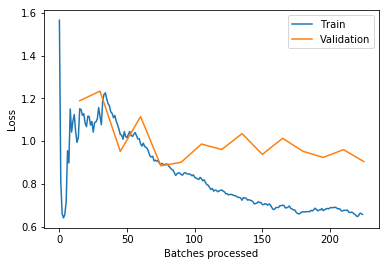

In [31]:
learnd14.fit_one_cycle(15)
learnd14.recorder.plot_losses()

In [32]:
learnd14.unfreeze()
learnd14.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


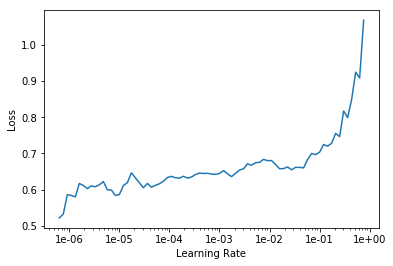

In [33]:
learnd14.recorder.plot()

epoch,train_loss,valid_loss,error_rate,time
0,0.664947,0.912032,0.666667,00:01
1,0.648999,0.886862,0.666667,00:01
2,0.657448,0.817981,0.666667,00:01
3,0.656307,0.894110,0.666667,00:01
4,0.664362,0.851289,0.555556,00:01
5,0.678952,0.711710,0.555556,00:01
6,0.681345,0.838891,0.666667,00:01
7,0.683375,0.761733,0.666667,00:01
8,0.689244,0.774249,0.666667,00:01
9,0.668785,0.791756,0.666667,00:01


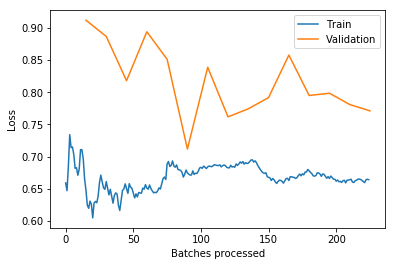

In [34]:
learnd14.fit_one_cycle(15)
learnd14.recorder.plot_losses()